In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold


import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [5]:
import xgboost
print(xgboost.__version__)


3.0.2


In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
original = pd.read_csv("data/Fertilizer Prediction.csv")

In [7]:
# Drop the 'id' column
X = train.drop(columns=['id', 'Fertilizer Name'])

# Extract the target column
y = train['Fertilizer Name']

X.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,37,70,36,Clayey,Sugarcane,36,4,5
1,27,69,65,Sandy,Millets,30,6,18
2,29,63,32,Sandy,Millets,24,12,16
3,35,62,54,Sandy,Barley,39,12,4
4,35,58,43,Red,Paddy,37,2,16


In [8]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Output labels are now numbers
y_encoded[:10]

array([4, 4, 2, 0, 5, 3, 4, 1, 2, 3])

In [9]:
# multiple copies of original dataset
orig_copy = original.copy()

n = 6
for i in range(n):
    original = pd.concat([original, orig_copy], axis=0, ignore_index=True)
    
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      700000 non-null  int64 
 1   Humidity         700000 non-null  int64 
 2   Moisture         700000 non-null  int64 
 3   Soil Type        700000 non-null  object
 4   Crop Type        700000 non-null  object
 5   Nitrogen         700000 non-null  int64 
 6   Potassium        700000 non-null  int64 
 7   Phosphorous      700000 non-null  int64 
 8   Fertilizer Name  700000 non-null  object
dtypes: int64(6), object(3)
memory usage: 48.1+ MB


In [10]:
train['Fertilizer Name'].value_counts()

Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64

In [11]:
orig_copy['Fertilizer Name'].value_counts()

Fertilizer Name
14-35-14    14492
10-26-26    14378
Urea        14325
28-28       14232
DAP         14220
20-20       14181
17-17-17    14172
Name: count, dtype: int64

In [12]:
# Store scores
f1_scores = []
map3_scores = []
models = []

# Collect predictions and true labels across all folds
all_y_true = []
all_y_pred = []

# Prepare K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded)):
    print(f"\n***** Fold {fold + 1} *****")

    # Make full copies to avoid warnings
    X_train = X.iloc[train_idx].copy()
    X_val = X.iloc[val_idx].copy()
    y_train = y_encoded[train_idx]
    y_val = y_encoded[val_idx]

    # Combine original with train data 
    X_train = pd.concat([X_train, original], ignore_index=True)
    y_train = np.concatenate([y_train, le.transform(original['Fertilizer Name'])])

    # Drop target column from training data
    X_train.drop(columns=['Fertilizer Name'], inplace=True)

    # Convert all features to categorical (except target, which is already separated)
    for col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        
    for col in X_val.columns:
        X_val[col] = X_val[col].astype('category')
    
    cat_features = X_train.columns.tolist()   # capture all input columns

    model = XGBClassifier(
                max_depth=7,
                colsample_bytree=0.4,
                subsample=0.8,
                n_estimators=10000,
                learning_rate=0.01,
                gamma=0.26,
                max_delta_step=4,
                reg_alpha=2.7,
                reg_lambda=1.4,
                objective='multi:softprob',
                random_state=13,
                enable_categorical=True,
                tree_method='hist',     
                device='cuda'  
            )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train),(X_val, y_val)],
        verbose=500,
    )
    
    # Predict class labels and probabilities
    y_pred = model.predict(X_val)
    y_probs = model.predict_proba(X_val)

    # Store predictions and true labels
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    # F1 Score
    report = classification_report(y_val, y_pred, output_dict=True)
    f1_macro = report["macro avg"]["f1-score"]
    f1_scores.append(f1_macro)
    
    # MAP@3
    top3_preds = np.argsort(y_probs, axis=1)[:, -3:][:, ::-1]
    
    def mapk(actual, predicted, k=3):
        def apk(a, p, k):
            if a in p[:k]:
                return 1.0 / (p[:k].index(a) + 1)
            return 0.0
        return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

    map3 = mapk(y_val.tolist(), top3_preds.tolist(), k=3)
    map3_scores.append(map3)
    models.append(model)

    print(f"F1 (macro): {f1_macro:.4f} | MAP@3: {map3:.4f}")

# Final Results
print("\n***** Final CV Results *****")
print(f"Avg F1: {np.mean(f1_scores):.4f}")
print(f"Avg MAP@3: {np.mean(map3_scores):.4f}")


***** Fold 1 *****
[0]	validation_0-mlogloss:1.94578	validation_1-mlogloss:1.94582
[500]	validation_0-mlogloss:1.89525	validation_1-mlogloss:1.92138
[1000]	validation_0-mlogloss:1.85663	validation_1-mlogloss:1.90996
[1500]	validation_0-mlogloss:1.82137	validation_1-mlogloss:1.90178
[2000]	validation_0-mlogloss:1.78904	validation_1-mlogloss:1.89543
[2500]	validation_0-mlogloss:1.75910	validation_1-mlogloss:1.89046
[3000]	validation_0-mlogloss:1.73145	validation_1-mlogloss:1.88673
[3500]	validation_0-mlogloss:1.70574	validation_1-mlogloss:1.88399
[4000]	validation_0-mlogloss:1.68154	validation_1-mlogloss:1.88199
[4500]	validation_0-mlogloss:1.65873	validation_1-mlogloss:1.88068
[5000]	validation_0-mlogloss:1.63685	validation_1-mlogloss:1.87985
[5500]	validation_0-mlogloss:1.61605	validation_1-mlogloss:1.87941
[6000]	validation_0-mlogloss:1.59648	validation_1-mlogloss:1.87935
[6500]	validation_0-mlogloss:1.57783	validation_1-mlogloss:1.87968
[7000]	validation_0-mlogloss:1.55992	validatio

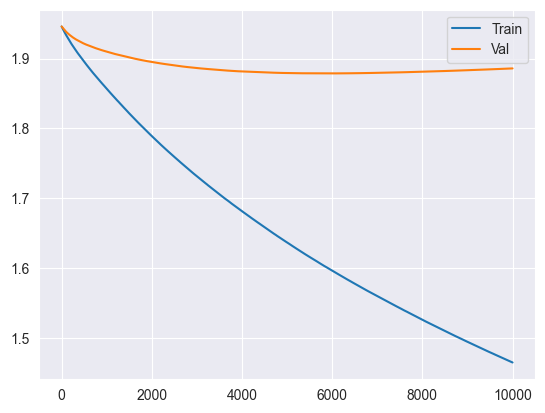

In [13]:
# Loss curves for the last fold
results = model.evals_result()
plt.plot(results['validation_0']['mlogloss'], label='Train')
plt.plot(results['validation_1']['mlogloss'], label='Val')
plt.legend()
plt.show()

In [14]:
# Convert test data
for col in cat_features:
    test[col] = test[col].astype('category')

all_preds = np.zeros((test.shape[0], len(le.classes_)))

X_test = test.drop(columns='id')
cat_features = X_test.columns.tolist()   

for model in models:
    probs = model.predict_proba(X_test)
    all_preds += probs

avg_preds = all_preds / len(models)

top3_preds = np.argsort(probs, axis=1)[:, -3:][:, ::-1] 

top3_labels = le.inverse_transform(top3_preds.ravel()).reshape(top3_preds.shape)

submission = pd.DataFrame({
    'id': test['id'], 
    'Fertilizer Name': [' '.join(row) for row in top3_labels]
})

submission.to_csv('submission.csv', index=False)
print("Done!")

submission.head()

Done!


,id,Fertilizer Name
0,750000,20-20 10-26-26 17-17-17
1,750001,Urea 10-26-26 17-17-17
2,750002,20-20 Urea DAP
3,750003,Urea 14-35-14 17-17-17
4,750004,Urea 20-20 28-28
